### Spatial Understanding with Qwen2.5-VL

This notebook showcases Qwen2.5-VL's advanced spatial localization abilities, including accurate object detection and specific target grounding within images. 

See how it integrates visual and linguistic understanding to interpret complex scenes effectively.

Prepare the environment

In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils
!pip install openai

#### \[Setup\]

Load visualization utils.

In [1]:
# @title Plotting Util

# Get Noto JP font to display janapese characters
# !apt-get install fonts-noto-cjk  # For Noto Sans CJK JP

#!apt-get install fonts-source-han-sans-jp # For Source Han Sans (Japanese)

import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
import xml.etree.ElementTree as ET
from IPython.display import display

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def decode_xml_points(text):
    try:
        root = ET.fromstring(text)
        num_points = (len(root.attrib) - 1) // 2
        points = []
        for i in range(num_points):
            x = root.attrib.get(f'x{i+1}')
            y = root.attrib.get(f'y{i+1}')
            points.append([x, y])
        alt = root.attrib.get('alt')
        phrase = root.text.strip() if root.text else None
        return {
            "points": points,
            "alt": alt,
            "phrase": phrase
        }
    except Exception as e:
        print(e)
        return None

def plot_bounding_boxes(im, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("/Users/lilyzhang/Library/Fonts/NotoSansCJK.ttc", size=14)

    try:
      json_output = ast.literal_eval(bounding_boxes)
    except Exception as e:
      end_idx = bounding_boxes.rfind('"}') + len('"}')
      truncated_text = bounding_boxes[:end_idx] + "]"
      json_output = ast.literal_eval(truncated_text)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    # img.show()
    display(img)


def plot_points(im, text, input_width, input_height):
  img = im
  width, height = img.size
  draw = ImageDraw.Draw(img)
  colors = [
    'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'brown', 'gray',
    'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy', 'maroon', 'teal',
    'olive', 'coral', 'lavender', 'violet', 'gold', 'silver',
  ] + additional_colors
  xml_text = text.replace('```xml', '')
  xml_text = xml_text.replace('```', '')
  data = decode_xml_points(xml_text)
  if data is None:
    img.show()
    return
  points = data['points']
  description = data['phrase']

  font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

  for i, point in enumerate(points):
    color = colors[i % len(colors)]
    abs_x1 = int(point[0])/input_width * width
    abs_y1 = int(point[1])/input_height * height
    radius = 2
    draw.ellipse([(abs_x1 - radius, abs_y1 - radius), (abs_x1 + radius, abs_y1 + radius)], fill=color)
    draw.text((abs_x1 + 8, abs_y1 + 6), description, fill=color, font=font)
  
  img.show()
  

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

Load model and processors.

In [ ]:
# need to download the model first
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
model_path = "Qwen/Qwen2.5-VL-7B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2",device_map="auto")
processor = AutoProcessor.from_pretrained(model_path)

Load inference function.

In [5]:
def inference(img_url, prompt, system_prompt="You are a helpful assistant", max_new_tokens=1024):
  image = Image.open(img_url)
  messages = [
    {
      "role": "system",
      "content": system_prompt
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "image": img_url
        }
      ]
    }
  ]
  text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  print("input:\n",text)
  inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt").to('cuda')

  output_ids = model.generate(**inputs, max_new_tokens=1024)
  generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
  output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
  print("output:\n",output_text[0])

  input_height = inputs['image_grid_thw'][0][1]*14
  input_width = inputs['image_grid_thw'][0][2]*14

  return output_text[0], input_height, input_width

inference function with API

In [4]:
from openai import OpenAI
from together import Together
import os
import base64
#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


# def inference_with_api(
#     image_path, 
#     prompt, 
#     sys_prompt="You are a helpful assistant.",
#     # model_id="Qwen/Qwen2.5-7B-Instruct-Turbo", turbo model does not work well
#     model_id="Qwen/Qwen2.5-VL-72B-Instruct",
#     min_pixels=512*28*28, 
#     max_pixels=2048*28*28
# ):
#     # Ensure API key is set
#     if "TOGETHER_API_KEY" not in os.environ:
#         raise ValueError("TOGETHER_API_KEY environment variable is not set")
    
#     base64_image = encode_image(image_path)
    
#     # Initialize Together client (will automatically use TOGETHER_API_KEY from environment)
#     client = Together()
    
#     messages=[
#         {
#             "role": "system",
#             "content": [{"type":"text","text": sys_prompt}]},
#         {
#             "role": "user",
#             "content": [
#                 {
#                     "type": "image_url",
#                     "min_pixels": min_pixels,
#                     "max_pixels": max_pixels,
#                     # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
#                     # PNG image:  f"data:image/png;base64,{base64_image}"
#                     # JPEG image: f"data:image/jpeg;base64,{base64_image}"
#                     # WEBP image: f"data:image/webp;base64,{base64_image}"
#                     "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
#                 },
#                 {"type": "text", "text": prompt},
#             ],
#         }
#     ]
#     completion = client.chat.completions.create(
#         model = model_id,
#         messages = messages,
       
#     )
    
#     return completion.choices[0].message.content

# @title inference function with API
def inference_with_api(image_path, prompt, sys_prompt="You are a helpful assistant.", 
                    #    model_id="qwen2.5-vl-72b-instruct", 
                    # model_id="qwen/qwen2.5-vl-72b-instruct:free",
                    # model_id="qwen/qwen-2.5-vl-7b-instruct:free",
                    # model_id="qwen/qwen2.5-vl-32b-instruct:free",
                    model_id="opengvlab/internvl3-14b",
                    min_pixels=512*28*28, max_pixels=2048*28*28):
    base64_image = encode_image(image_path)
    client = OpenAI(
        #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx".
        api_key=os.getenv('OPENROUTER_API_KEY'),
        base_url="https://openrouter.ai/api/v1",
    )


    messages=[
        {
            "role": "system",
            "content": [{"type":"text","text": sys_prompt}]},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                    # PNG image:  f"data:image/png;base64,{base64_image}"
                    # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                    # WEBP image: f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
       
    )
    return completion.choices[0].message.content

In [13]:
def parse_internvl3_response(response_text):
    """
    Parse InternVL3 response and convert to the expected format.
    Handles multiple response formats from InternVL3.
    """
    # Extract JSON from the response
    try:
        # Find the JSON block - could start with { or [
        json_start = response_text.find('```json')
        if json_start == -1:
            return None
        
        # Look for either { or [ as the start of JSON
        brace_start = response_text.find('{', json_start)
        bracket_start = response_text.find('[', json_start)
        
        if brace_start == -1 and bracket_start == -1:
            return None
        
        # Choose the first valid start position
        if brace_start == -1:
            json_start = bracket_start
            json_end = response_text.rfind(']') + 1
        elif bracket_start == -1:
            json_start = brace_start
            json_end = response_text.rfind('}') + 1
        else:
            if brace_start < bracket_start:
                json_start = brace_start
                json_end = response_text.rfind('}') + 1
            else:
                json_start = bracket_start
                json_end = response_text.rfind(']') + 1
        
        json_str = response_text[json_start:json_end]
        
        # Parse the JSON
        data = json.loads(json_str)
        
        # Convert to expected format
        converted_data = []
        
        # Format 1: Direct array with bbox format [x_min, y_min, x_max, y_max]
        if isinstance(data, list):
            for item in data:
                if 'bbox' in item:
                    # Already in correct format [x1, y1, x2, y2]
                    bbox = item['bbox']
                    converted_data.append({
                        'bbox_2d': bbox,
                        'label': item.get('category', item.get('type', item.get('name', 'object')))
                    })
                elif 'position' in item:
                    # Convert from x, y, width, height format
                    pos = item['position']
                    x1 = pos['x']
                    y1 = pos['y']
                    x2 = pos['x'] + pos['width']
                    y2 = pos['y'] + pos['height']
                    
                    converted_data.append({
                        'bbox_2d': [x1, y1, x2, y2],
                        'label': item.get('category', item.get('type', item.get('name', 'object')))
                    })
        
        # Format 2: Object with nested arrays (like traffic_signs)
        elif isinstance(data, dict):
            for key, value in data.items():
                if isinstance(value, list):
                    for item in value:
                        if 'bbox' in item:
                            # Direct bbox format
                            bbox = item['bbox']
                            converted_data.append({
                                'bbox_2d': bbox,
                                'label': item.get('category', item.get('type', item.get('name', key.rstrip('s'))))
                            })
                        elif 'position' in item:
                            # Position format (x, y, width, height)
                            pos = item['position']
                            x1 = pos['x']
                            y1 = pos['y']
                            x2 = pos['x'] + pos['width']
                            y2 = pos['y'] + pos['height']
                            
                            converted_data.append({
                                'bbox_2d': [x1, y1, x2, y2],
                                'label': item.get('category', item.get('type', item.get('name', key.rstrip('s'))))
                            })
        
        return converted_data
    except Exception as e:
        print(f"Error parsing InternVL3 response: {e}")
        print(f"Attempted to parse JSON: {json_str[:200] if 'json_str' in locals() else 'Could not extract JSON'}...")
        return None

def plot_internvl3_bounding_boxes(im, response_text, input_width, input_height):
    """
    Plots bounding boxes from InternVL3 response format
    """
    img = im.copy()
    width, height = img.size
    print(f"Image size: {img.size}")
    
    # Create a drawing object
    draw = ImageDraw.Draw(img)
    
    # Define colors
    colors = [
        'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'brown', 'gray',
        'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy', 'maroon', 'teal',
        'olive', 'coral', 'lavender', 'violet', 'gold', 'silver',
    ] + additional_colors
    
    # Parse the response
    bounding_boxes = parse_internvl3_response(response_text)
    
    if not bounding_boxes:
        print("Could not parse bounding boxes from response")
        display(img)
        return
    
    font = ImageFont.truetype("/Users/lilyzhang/Library/Fonts/NotoSansCJK.ttc", size=14)
    
    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(bounding_boxes):
        # Select a color from the list
        color = colors[i % len(colors)]
        
        # Get coordinates (assuming they're already in absolute pixel coordinates)
        x1, y1, x2, y2 = bounding_box["bbox_2d"]
        
        # Ensure coordinates are in the right order
        if x1 > x2:
            x1, x2 = x2, x1
        if y1 > y2:
            y1, y2 = y2, y1
        
        # Draw the bounding box
        draw.rectangle(((x1, y1), (x2, y2)), outline=color, width=4)
        
        # Draw the text
        if "label" in bounding_box:
            draw.text((x1 + 8, y1 + 6), bounding_box["label"], fill=color, font=font)
    
    # Display the image
    display(img)


In [14]:
def plot_classification_result(im, response, input_width, input_height):
    """
    Plots classification result on the image with bold text
    """
    img = im.copy()
    draw = ImageDraw.Draw(img)
    
    # Use larger font size
    font = ImageFont.truetype("/Users/lilyzhang/Library/Fonts/NotoSansCJK.ttc", size=14)
    
    # Parse the response
    try:
        response = response.replace('```json\n', '').replace('\n```', '')
        result = json.loads(response)
        has_human = result.get('has_human', False)
        text = f"Human:\n {str(has_human)}"
    except:
        has_human = response.strip().lower() == 'true'
        text = f"Human:\n {str(has_human)}"
    
    # Position for text
    x, y = 10, 0
    color = 'green' if has_human else 'red'
    
    # Create bold effect by drawing text multiple times with tiny offsets
    offsets = [
        (0,0), (1,0), (-1,0),  # horizontal offsets
        (0,1), (0,-1),         # vertical offsets
        (1,1), (-1,-1),        # diagonal offsets
        (1,-1), (-1,1),        # diagonal offsets
        # (2,0), (-2,0),         # extra horizontal boldness
        # (0,2), (0,-2)          # extra vertical boldness
    ]
    
    # Draw all offset layers in the same color
    for dx, dy in offsets:
        draw.text((x + dx, y + dy), text, font=font, fill=color)
    
    # Display in notebook
    display(img)
    
    return has_human

#### 1. Detect certain object in the image

Let's start with a simple scenario where we want to locate certain objects in an image.

Besides, we can further prompt the model to describe their unique characteristics or features by explicitly giving that order.

In [12]:
# image_path = "./assets/spatial_understanding/cakes.png"
# sensor obstruction
# image_path = "./assets/spatial_understanding/av/sensor_obstruction_n008-2018-06-04-16-30-00-0400__CAM_BACK__1528144232887570.jpg"
# night small vehicle
# image_path = "./assets/spatial_understanding/av/night_n005-2018-06-14-20-11-03+0800__CAM_BACK__1528979868187591.jpg"
# Day sign
# image_path = "./assets/spatial_understanding/av/sign_n013-2018-08-20-14-38-24+0800__CAM_BACK__1534747168787005.jpg"
# traffic light
# image_path = "./assets/spatial_understanding/av/traffic_light_camera_1_1555706641900051_focus.png"
# image_path = "./assets/spatial_understanding/av/traffic_light_camera_1_1555706641900051_human.png"
# image_path = "./assets/spatial_understanding/av/vru_n010-2018-09-17-15-57-10+0800__CAM_FRONT_LEFT__1537171282504509.jpg"

#night crop
# image_path = "./assets/spatial_understanding/av/night_n005-2018-06-14-20-11-03+0800__CAM_BACK__1528979868187591_crop.jpg"
# image_path = "./assets/spatial_understanding/av/night_camera_1_time_1558060923374527_img_0_focus.jpeg"
image_path = "./assets/spatial_understanding/av/traffic_sign_1.png"



## Use a local HuggingFace model to inference.
# prompt in chinese
# prompt = "框出每一个小蛋糕的位置，以json格式输出所有的坐标"
# prompt in english
# prompt = "Outline the position of every single small cake and output all the coordinates in JSON format."

prompt = "Outline the position of every vehicle and output bbox for each object.Please output all objects in the JSON format: [{'category1': '<bbox1>'}, {'category2': '<bbox2>'}]"

# prompt = "This is at night, first propose the rough regions of pedestrian, then within these outlined region, accurately outline each human, output all the coordinates in JSON format."
# prompt = "Analyze this image and determine if there are any humans present. Respond in JSON format: {\"has_human\": true/false}"
# response, input_height, input_width = inference(image_path, prompt)

# image = Image.open(image_path)
# print(image.size)
# image.thumbnail([640,640], Image.Resampling.LANCZOS)
# plot_bounding_boxes(image,response,input_width,input_height)


# Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# os.environ['TOGETHER_API_KEY'] = 'your_api_key_here' 
os.environ['OPENROUTER_API_KEY'] ='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'
import os
print(os.environ.get('OPENROUTER_API_KEY'))

min_pixels = 512*28*28
max_pixels = 2048*28*28
# min_pixels = 1280*28*28 #512*28*28
# max_pixels = 3072*28*28 #2048*28*28
image = Image.open(image_path)
width, height = image.size
print(image.size)
input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
response


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
(1209, 673)


'To outline the position of every vehicle in the image and output bounding boxes for each, we\'ll first identify and label the vehicles. We have two self-driving cars (Waymo), a motorcycle, and a pedestrian.\n\nBounding boxes are defined as `[x_min, y_min, x_max, y_max]`, where:\n- `x_min` and `y_min` are the coordinates of the top-left corner.\n- `x_max` and `y_max` are the coordinates of the bottom-right corner.\n\nHere is the JSON representation of each object:\n\n```json\n[\n    {\n        "category": "Waymo Car 1",\n        "bbox": [30, 240, 200, 550]\n    },\n    {\n        "category": "Waymo Car 2",\n        "bbox": [328, 256, 922, 827]\n    },\n    {\n        "category": "Motorcycle",\n        "bbox": [230, 350, 352, 512]\n    },\n    {\n        "category": "Pedestrian",\n        "bbox": [378, 365, 425, 505]\n    }\n]\n```\n\n### Explanation of Bounding Boxes:\n\n1. **Waymo Car 1**:\n   - Located at the front-left, facing towards the camera.\n   - Bounding box covers from the l

Image size: (1209, 673)


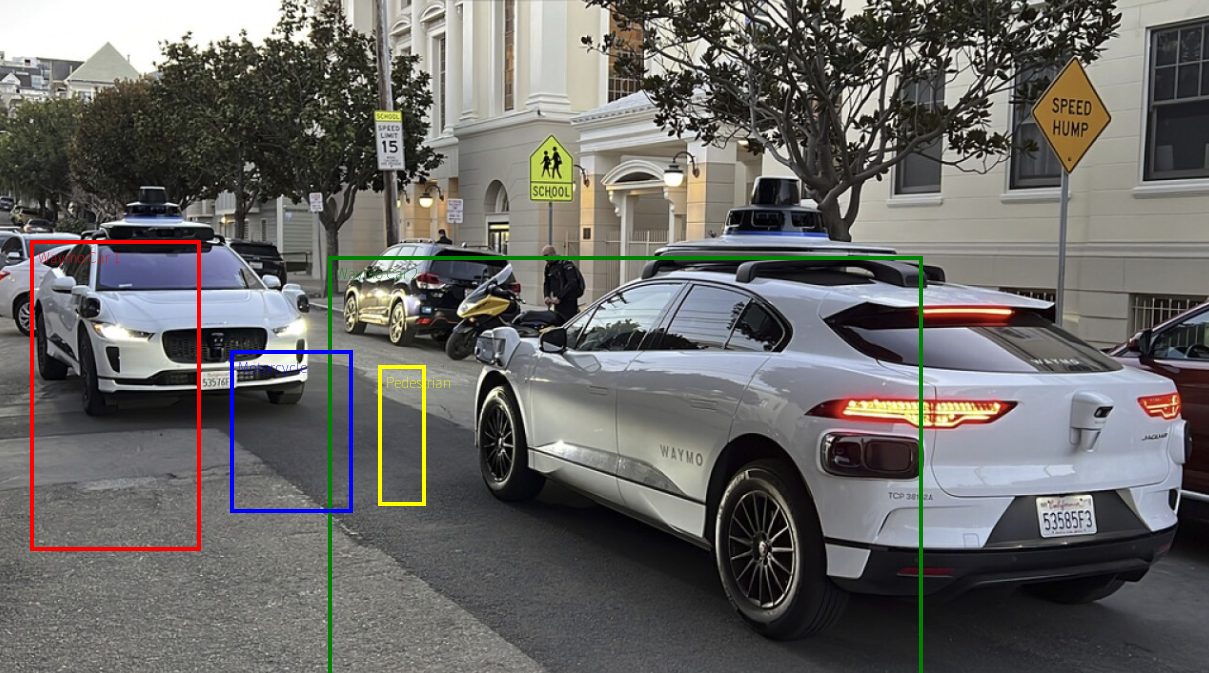

In [15]:
# Use the new function for InternVL3 response format
plot_internvl3_bounding_boxes(image, response, input_width, input_height)

In [ ]:
# Example of using the InternVL3 plotting function
# The response from InternVL3 should be in the format like:
# ```json
# {
#   "traffic_signs": [
#     {
#       "type": "Speed Limit",
#       "position": {
#         "x": 300,
#         "y": 200,
#         "width": 50,
#         "height": 100
#       }
#     }
#   ]
# }
# ```

# For testing with the actual response text, you can use:
internvl3_response = '''To identify and outline the position of every single traffic sign in the image and provide the coordinates in JSON format, I'll first analyze the image and locate each sign. The coordinates will be relative to the image dimensions.

Here are the positions of the traffic signs:

1. **School Zone Speed Limit 15**
2. **School Crosswalk Sign**
3. **Speed Hump Sign**

Let's define each of these with coordinates in JSON format.

```json
{
  "traffic_signs": [
    {
      "type": "Speed Limit",
      "position": {
        "x": 300,
        "y": 200,
        "width": 50,
        "height": 100
      }
    },
    {
      "type": "School Crosswalk",
      "position": {
        "x": 380,
        "y": 180,
        "width": 70,
        "height": 150
      }
    },
    {
      "type": "Speed Hump",
      "position": {
        "x": 850,
        "y": 90,
        "width": 70,
        "height": 140
      }
    }
  ]
}
```

In this JSON:
- `x` and `y` represent the position of the top-left corner of the bounding box of the sign.
- `width` and `height` define the dimensions of the bounding box around the sign.
- The coordinates are approximate based on visual inspection of the image. Adjustments may be needed for precise applications.'''

# Test the parsing function
test_result = parse_internvl3_response(internvl3_response)
print("Parsed result:", test_result)


In [ ]:
# Test the updated parsing function with the vehicle detection response format
vehicle_response = '''To outline the position of every vehicle in the image and output bounding boxes for each, we'll first identify and label the vehicles. We have two self-driving cars (Waymo), a motorcycle, and a pedestrian.

Bounding boxes are defined as `[x_min, y_min, x_max, y_max]`, where:
- `x_min` and `y_min` are the coordinates of the top-left corner.
- `x_max` and `y_max` are the coordinates of the bottom-right corner.

Here is the JSON representation of each object:

```json
[
    {
        "category": "Waymo Car 1",
        "bbox": [30, 240, 200, 550]
    },
    {
        "category": "Waymo Car 2", 
        "bbox": [328, 256, 922, 827]
    },
    {
        "category": "Motorcycle",
        "bbox": [230, 350, 352, 512]
    },
    {
        "category": "Pedestrian",
        "bbox": [378, 365, 425, 505]
    }
]
```

### Explanation of Bounding Boxes:

1. **Waymo Car 1**:
   - Located at the front-left, facing towards the camera.
   - Bounding box covers from the left edge to the right edge of the vehicle and from the top to the bottom.

2. **Waymo Car 2**:
   - Located at the front-right, facing away from the camera.
   - Bounding box captures the entire car, including the roof-mounted sensors.

3. **Motorcycle**:
   - Parked behind Waymo Car 2 on the sidewalk.
   - Bounding box encompasses the entire motorcycle.

4. **Pedestrian**:
   - Positioned next to the motorcycle.
   - Bounding box captures the pedestrian standing on the sidewalk.

These coordinates are approximate and visually estimated based on the image.'''

# Test the parsing with this new format
test_vehicle_result = parse_internvl3_response(vehicle_response)
print("Parsed vehicle detection result:")
for i, item in enumerate(test_vehicle_result):
    print(f"{i+1}. {item['label']}: {item['bbox_2d']}")

print("\nThe updated function now handles both formats:")
print("- Traffic signs format: nested object with 'position' (x, y, width, height)")
print("- Vehicle/object format: direct array with 'bbox' [x_min, y_min, x_max, y_max]")


In [ ]:
# Example of using the updated plotting function with vehicle detection
# If you have a vehicle detection response, you can now use:

# For testing purposes, let's create a sample image and test the plotting
# (In practice, you would use your actual image and InternVL3 response)

# Example usage:
# image = Image.open("your_vehicle_image.jpg")  
# response = inference_with_api("your_vehicle_image.jpg", "Outline the position of every vehicle...")
# plot_internvl3_bounding_boxes(image, response, input_width, input_height)

print("Updated parsing function now supports:")
print("✓ Traffic signs format: {...'traffic_signs': [{'type': '...', 'position': {'x': ..., 'y': ..., 'width': ..., 'height': ...}}]}")  
print("✓ Vehicle/object format: [{'category': '...', 'bbox': [x_min, y_min, x_max, y_max]}]")
print("✓ Generic object format: [{'name': '...', 'bbox': [...]}] or [{'type': '...', 'bbox': [...]}]")
print("✓ Nested format: {'objects': [{'category': '...', 'bbox': [...]}]}")

print("\nThe plot_internvl3_bounding_boxes function will work with any of these formats!")


In [67]:
# plot_bounding_boxes(image, response, input_width, input_height)

#### 2. Detect a specific object using descriptions

Further, you can search for a specific object by using a short phrase or sentence to describe it.

In [ ]:
image_path = "./assets/spatial_understanding/cakes.png"

# prompt in chinses
prompt = "定位最右上角的棕色蛋糕，以JSON格式输出其bbox坐标"
# prompt in english
prompt = "Locate the top right brown cake, output its bbox coordinates using JSON format."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image,response,input_width,input_height)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 3. Point to certain objects in xml format

In addition to the above mentioned bbox format [x1, y1, x2, y2], Qwen2.5-VL also supports point-based grounding. You can point to a specific object and the model is trained to output xml-style results.

In [ ]:
image_path = "./assets/spatial_understanding/cakes.png"

# prompt in chinese
prompt = "以点的形式定位图中桌子远处的擀面杖，以XML格式输出其坐标"
# prompt in english
prompt = "point to the rolling pin on the far side of the table, output its coordinates in XML format <points x y>object</points>"

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_points(image, response, input_width, input_height)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_points(image, response, input_width, input_height)

#### 4. Reasoning capability

In [ ]:
image_path = "./assets/spatial_understanding/Origamis.jpg"

# prompt in chinese
prompt = "框出图中纸狐狸的影子，以json格式输出其bbox坐标"
# prompt in english
prompt = "Locate the shadow of the paper fox, report the bbox coordinates in JSON format."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, response, input_width, input_height)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 5. Understand relationships across different instances

In [ ]:
image_path = "./assets/spatial_understanding/cartoon_brave_person.jpeg"

# prompt in chinese
prompt = "框出图中见义勇为的人，以json格式输出其bbox坐标"
# prompt in english
prompt = "Locate the person who act bravely, report the bbox coordinates in JSON format."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, response, input_width, input_height)


## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 6. Find a special instance with unique characteristic (color, location, utility, ...)

In [ ]:
url = "./assets/spatial_understanding/multiple_items.png"

# prompt in chinese
prompt = "如果太阳很刺眼，我应该用这张图中的什么物品，框出该物品在图中的bbox坐标，并以json格式输出"
# prompt in english
prompt = "If the sun is very glaring, which item in this image should I use? Please locate it in the image with its bbox coordinates and its name and output in JSON format."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(url, prompt)

image = Image.open(url)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, response, input_width, input_height)


## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 7. Use Qwen2.5-VL grounding capabilities to help counting

In [ ]:
image_path = "./assets/spatial_understanding/multiple_items.png"

# prompt in chinese
prompt = "请以JSON格式输出图中所有物体bbox的坐标以及它们的名字，然后基于检测结果回答以下问题：图中物体的数目是多少？"
# prompt in english
prompt = "Please first output bbox coordinates and names of every item in this image in JSON format, and then answer how many items are there in the image."

## Use a local HuggingFace model to inference.
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image,response,input_width,input_height)

# # Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
# image = Image.open(image_path)
# width, height = image.size
# input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# plot_bounding_boxes(image, response, input_width, input_height)

#### 8. spatial understanding with designed system prompt
The above usage is based on the default system prompt. You can also change the system prompt to obtain other output format like plain text.
Qwen2.5-VL now support these formats:
* bbox-format: JSON

`{"bbox_2d": [x1, y1, x2, y2], "label": "object name/description"}`

* bbox-format: plain text

`x1,y1,x2,y2 object_name/description`

* point-format: XML

`<points x y>object_name/description</points>`

* point-format: JSON

`{"point_2d": [x, y], "label": "object name/description"}`

Change your system prompt to use plain text as output format

In [ ]:
image_path = "./assets/spatial_understanding/cakes.png"
image = Image.open(image_path)
system_prompt = "As an AI assistant, you specialize in accurate image object detection, delivering coordinates in plain text format 'x1,y1,x2,y2 object'."
prompt = "find all cakes"
response, input_height, input_width = inference(image_path, prompt, system_prompt=system_prompt)



## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 
# response = inference_with_api(image_path, prompt, sys_prompt=system_prompt)
# print(response)
